# Image Compression 


In [39]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from ProcessData import *
import cvxpy as cp
from Calculation import *
from BIHT import *
from Visualization import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# 导入数据
train_file = 'mnist_train.csv'
test_file = 'mnist_test.csv'

with open(train_file, 'r') as f:
    train_data_reader = csv.reader(f)
    train_data = list(train_data_reader)
    train_data_array = np.array(train_data, dtype=float)  # 转换为浮点数类型
    
with open(test_file, 'r') as f:
    test_data_reader = csv.reader(f)
    test_data = list(test_data_reader)
    test_data_array = np.array(test_data, dtype=float)  # 转换为浮点数类型

print(f'Size of Training Set：{np.shape(train_data_array)}')
print(f'Size of Testing Set: {np.shape(test_data_array)}')

# 分离标签和特征, 我们不需要标签
y_train = train_data_array[:, 0]  # 第一列是标签
X_train = train_data_array[:, 1:]  # 剩余的列是特征

y_test = test_data_array[:, 0]  # 第一列是标签
X_test = test_data_array[:, 1:]  # 剩余的列是特征

# 对原始图像归一化，见BIHT论文
for i in range(X_train.shape[0]):
    norm = np.linalg.norm(X_train[i])
    if norm > 0:
        X_train[i] = X_train[i] / norm

for i in range(X_test.shape[0]):
    norm = np.linalg.norm(X_test[i])
    if norm > 0:
        X_test[i] = X_test[i] / norm

print(f'训练标签形状: {y_train.shape}')
print(f'训练特征形状: {X_train.shape}')
print(f'测试标签形状: {y_test.shape}')
print(f'测试特征形状: {X_test.shape}')


Size of Training Set：(60000, 785)
Size of Testing Set: (10000, 785)
训练标签形状: (60000,)
训练特征形状: (60000, 784)
测试标签形状: (10000,)
测试特征形状: (10000, 784)


## 1.1 Generate Matrix A

In [45]:

Matrix_A_25_784 = Generate_Standard_Matrix_A(25, 784)    # 调用, 产生25x25的随机高斯矩阵A，其中每一列已经单位l2norm了
Matrix_A_100_784 = Generate_Standard_Matrix_A(100, 784)
Matrix_A_200_784 = Generate_Standard_Matrix_A(200, 784)
Matrix_A_500_784 = Generate_Standard_Matrix_A(500, 784)

## 1.2 Apply Sign Function

In [14]:
# 对Ax施加sign函数，获得全1或者-1的值
x_true = X_train[100]
y_25_784 = np.sign(Matrix_A_25_784 @ x_true)     # (25, )
y_100_784 = np.sign(Matrix_A_100_784 @ x_true)
y_200_784 = np.sign(Matrix_A_200_784 @ x_true)
y_500_784 = np.sign(Matrix_A_500_784 @ x_true)

# 1.3 See the recovery of the selected image


0.060422842748633
0.060422842748633
[ 0.         -0.         -0.          0.         -0.         -0.
 -0.          0.          0.         -0.          0.         -0.
  0.         -0.          0.         -0.         -0.         -0.
  0.         -0.          0.         -0.         -0.          0.
  0.          0.         -0.         -0.         -0.          0.03118887
  0.          0.          0.          0.          0.          0.
 -0.          0.          0.         -0.          0.          0.
  0.          0.         -0.         -0.          0.         -0.
  0.         -0.          0.         -0.         -0.          0.
  0.          0.         -0.          0.          0.         -0.
  0.         -0.          0.         -0.          0.         -0.
 -0.          0.         -0.          0.         -0.         -0.
  0.         -0.         -0.          0.          0.          0.
 -0.         -0.          0.          0.         -0.         -0.
 -0.          0.          0.         -0.015614

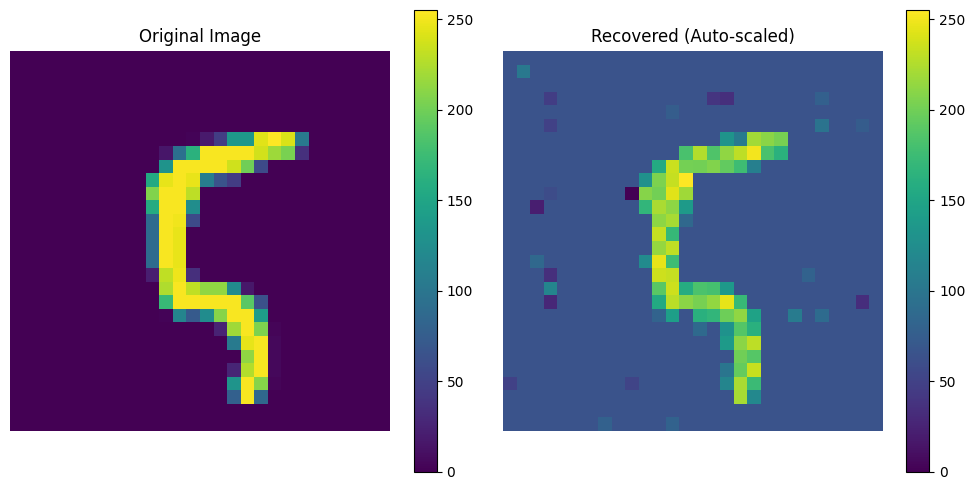

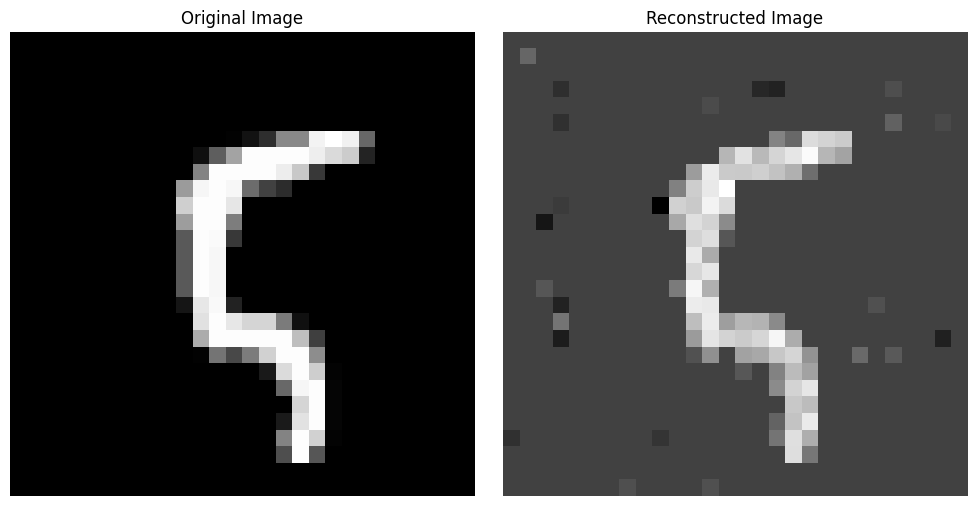

In [23]:

x_recovered = biht(Matrix_A_500_784, y_500_784, Calculate_Sparse(x_true), tau=0.01, max_iter=2000)
# display_recovered_image(x_recovered, x_true)
mse, nmse = compute_metrics(x_true, x_recovered)
print(mse)
print(nmse)
print(x_recovered)
print(x_true)

display_recovered_image_color(x_recovered, x_true)
display_recovered_image(x_recovered, x_true)

# 2.1 Try A Several

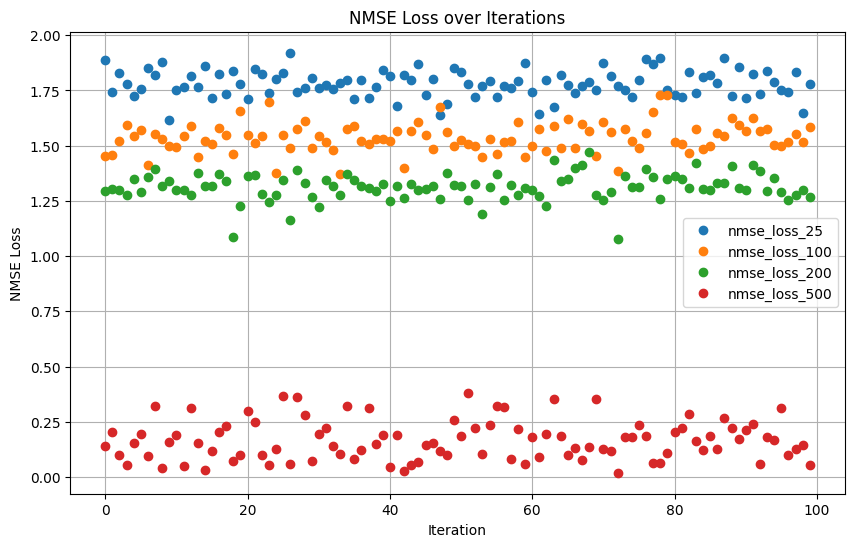

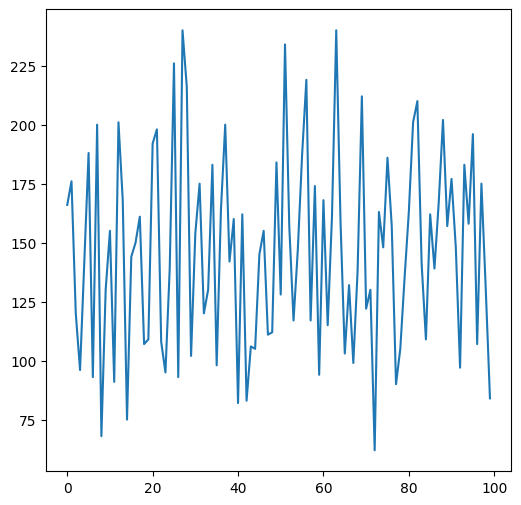

In [31]:
nmse_loss_25 = []
nmse_loss_100 = []
nmse_loss_200 = []
nmse_loss_500 = []
sparsity_list = []
for i in range(100):
    Matrix_A_25_784 = Generate_Standard_Matrix_A(25, 784)    # 调用, 产生25x25的随机高斯矩阵A，其中每一列已经单位l2norm了
    Matrix_A_100_784 = Generate_Standard_Matrix_A(100, 784)
    Matrix_A_200_784 = Generate_Standard_Matrix_A(200, 784)
    Matrix_A_500_784 = Generate_Standard_Matrix_A(1500, 784)

    x_true = X_train[i]
    y_25_784 = np.sign(Matrix_A_25_784 @ x_true)     # (25, )
    y_100_784 = np.sign(Matrix_A_100_784 @ x_true)
    y_200_784 = np.sign(Matrix_A_200_784 @ x_true)
    y_500_784 = np.sign(Matrix_A_500_784 @ x_true)
    sparsity = Calculate_Sparse(x_true)
    sparsity_list.append(sparsity)

    x_recovered = biht(Matrix_A_25_784, y_25_784, sparsity, tau=0.01, max_iter=2000)
    mse, nmse = compute_metrics(x_true, x_recovered)
    nmse_loss_25.append(nmse)

    x_recovered = biht(Matrix_A_100_784, y_100_784, sparsity, tau=0.01, max_iter=2000)
    mse, nmse = compute_metrics(x_true, x_recovered)
    nmse_loss_100.append(nmse)

    x_recovered = biht(Matrix_A_200_784, y_200_784, sparsity, tau=0.01, max_iter=2000)
    mse, nmse = compute_metrics(x_true, x_recovered)
    nmse_loss_200.append(nmse)

    x_recovered = biht(Matrix_A_500_784, y_500_784, sparsity, tau=0.01, max_iter=2000)
    mse, nmse = compute_metrics(x_true, x_recovered)
    nmse_loss_500.append(nmse)

plt.figure(figsize=(10, 6))
plt.plot(nmse_loss_25, 'o', label="nmse_loss_25")
plt.plot(nmse_loss_100, 'o', label="nmse_loss_100")
plt.plot(nmse_loss_200, 'o', label="nmse_loss_200")
plt.plot(nmse_loss_500, 'o', label="nmse_loss_500")

# 添加图例和标签
plt.xlabel("Iteration")
plt.ylabel("NMSE Loss")
plt.title("NMSE Loss over Iterations")
plt.legend()
plt.grid(True)

# 显示图像
plt.show()


plt.figure(figsize=(6, 6))
plt.plot(sparsity_list, 'o')
plt.title("Sparsity Levels")
plt.xlabel("Samples")
plt.ylabel("sparsity Level")
plt.show()

# 2.2 Deep Learning Methods: MLP

批次输入形状: torch.Size([64, 500])
批次目标形状: torch.Size([64, 784])
使用设备: cuda
Epoch [1/50], Train Loss: 0.000395, Test Loss: 0.000266, NMSE: 0.222069
Epoch [2/50], Train Loss: 0.000253, Test Loss: 0.000226, NMSE: 0.186752
Epoch [3/50], Train Loss: 0.000222, Test Loss: 0.000203, NMSE: 0.166753
Epoch [4/50], Train Loss: 0.000202, Test Loss: 0.000189, NMSE: 0.154267
Epoch [5/50], Train Loss: 0.000189, Test Loss: 0.000180, NMSE: 0.146628
Epoch [6/50], Train Loss: 0.000182, Test Loss: 0.000175, NMSE: 0.142236
Epoch [7/50], Train Loss: 0.000177, Test Loss: 0.000170, NMSE: 0.138178
Epoch [8/50], Train Loss: 0.000174, Test Loss: 0.000170, NMSE: 0.138086
Epoch [9/50], Train Loss: 0.000171, Test Loss: 0.000167, NMSE: 0.135513
Epoch [10/50], Train Loss: 0.000170, Test Loss: 0.000165, NMSE: 0.134061
Epoch [11/50], Train Loss: 0.000168, Test Loss: 0.000165, NMSE: 0.133392
Epoch [12/50], Train Loss: 0.000167, Test Loss: 0.000164, NMSE: 0.132988
Epoch [13/50], Train Loss: 0.000166, Test Loss: 0.000164, NMSE

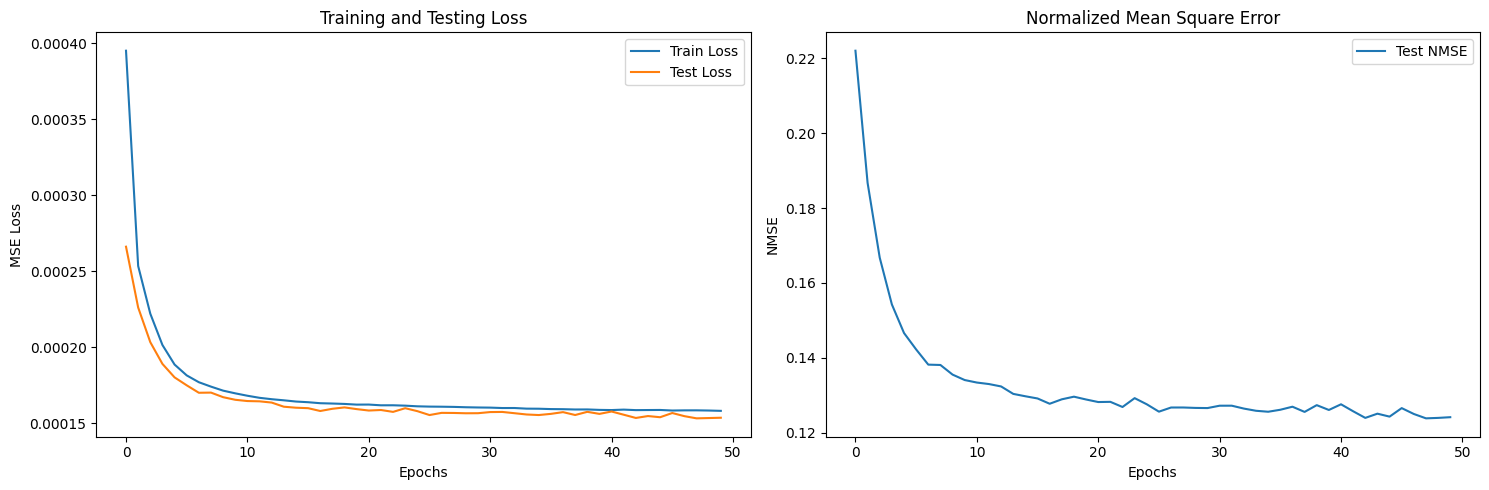

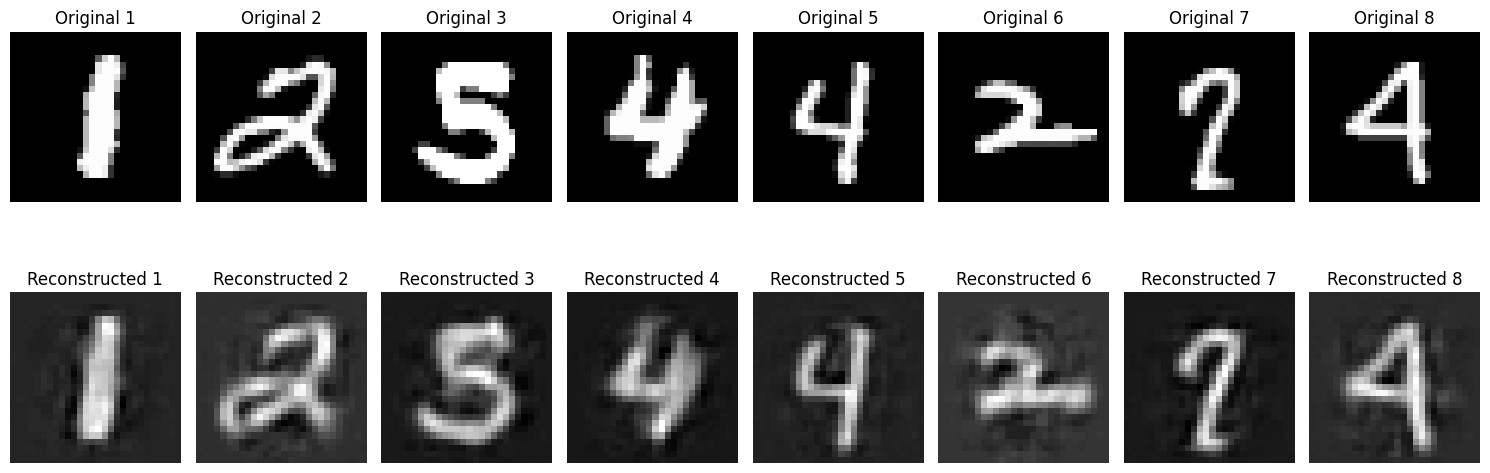

最终的NMSE: 0.124132


In [46]:
def generate_measurements(X, A):
    # 对每个样本计算1-bit测量
    y = np.sign(A @ X.T).T
    return y

# 生成训练集和测试集的1-bit测量
y_train = generate_measurements(X_train, Matrix_A_500_784)
y_test = generate_measurements(X_test, Matrix_A_500_784)

def create_data_loaders(y_data, x_data, batch_size=64):
    # 转换为PyTorch张量
    y_tensor = torch.from_numpy(y_data).float()
    x_tensor = torch.from_numpy(x_data).float()
    
    # 创建数据集
    dataset = TensorDataset(y_tensor, x_tensor)
    
    # 创建数据加载器
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return data_loader

# 创建训练和测试数据加载器
train_loader = create_data_loaders(y_train, X_train)
test_loader = create_data_loaders(y_test, X_test, batch_size=100)

# 检查数据加载器是否正确创建
for inputs, targets in train_loader:
    print(f"批次输入形状: {inputs.shape}")
    print(f"批次目标形状: {targets.shape}")
    break

# 步骤3: 定义MLP模型
class OnebitCSMLP(nn.Module):
    def __init__(self, input_dim=500, output_dim=784):
        super(OnebitCSMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
        )
    
    def forward(self, x):
        return self.model(x)

# 步骤4: 训练函数
def train_model(model, train_loader, test_loader, num_epochs=50, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"使用设备: {device}")
    
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    test_losses = []
    test_nmses = []
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        epoch_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # 测试阶段
        model.eval()
        test_loss = 0
        all_outputs = []
        all_targets = []
        
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
                
                all_outputs.append(outputs.cpu().numpy())
                all_targets.append(targets.cpu().numpy())
        
        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        
        # 计算NMSE
        outputs_array = np.vstack(all_outputs)
        targets_array = np.vstack(all_targets)
        
        # 归一化
        outputs_norm = outputs_array / np.linalg.norm(outputs_array, axis=1, keepdims=True)
        targets_norm = targets_array / np.linalg.norm(targets_array, axis=1, keepdims=True)
        
        nmse = np.mean(np.sum((outputs_norm - targets_norm)**2, axis=1))
        test_nmses.append(nmse)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}, NMSE: {nmse:.6f}')
    
    # 绘制训练曲线
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.title('Training and Testing Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(test_nmses, label='Test NMSE')
    plt.xlabel('Epochs')
    plt.ylabel('NMSE')
    plt.title('Normalized Mean Square Error')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model, train_losses, test_losses, test_nmses

# 步骤5: 评估函数 - 可视化一些重建结果
def visualize_results(model, test_loader, num_samples=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    all_inputs = []
    all_targets = []
    all_outputs = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            
            all_inputs.append(inputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())
            
            if len(all_inputs) * inputs.shape[0] >= num_samples:
                break
    
    inputs_array = np.vstack(all_inputs)[:num_samples]
    targets_array = np.vstack(all_targets)[:num_samples]
    outputs_array = np.vstack(all_outputs)[:num_samples]
    
    plt.figure(figsize=(15, 6))
    
    for i in range(num_samples):
        # 原始图像
        plt.subplot(2, num_samples, i+1)
        plt.imshow(targets_array[i].reshape(28, 28), cmap='gray')
        plt.title(f'Original {i+1}')
        plt.axis('off')
        
        # 重建图像
        plt.subplot(2, num_samples, i+1+num_samples)
        plt.imshow(outputs_array[i].reshape(28, 28), cmap='gray')
        plt.title(f'Reconstructed {i+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# 步骤6: 执行训练和评估
model = OnebitCSMLP(input_dim=500, output_dim=784)
model, train_losses, test_losses, test_nmses = train_model(model, train_loader, test_loader, num_epochs=50)

# 训练完成后，可视化一些结果
visualize_results(model, test_loader, num_samples=8)

# 保存模型（可选）
torch.save(model.state_dict(), 'onebit_cs_mlp_25.pth')

# 打印最终的NMSE
final_nmse = test_nmses[-1]
print(f"最终的NMSE: {final_nmse:.6f}")